In [1]:
# imports
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from scipy import io
import numpy as np

In [2]:
# mounting google drive locally

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

In [4]:
base_dir='/content/drive/MyDrive/m/'
train_dir='/content/drive/MyDrive/m/train/'
val_dir='/content/drive/MyDrive/m/val/'

In [5]:
#hyperparameters
batch_size=32
img_size=(150,150)

# by default, class names are infered, and converted to int
train_dataset = tf.keras.utils.image_dataset_from_directory(
                                                            directory = train_dir,
                                                            validation_split=0.3,
                                                            subset='training',
                                                            shuffle=True,
                                                            seed=1,
                                                            batch_size=batch_size,
                                                            image_size=img_size
                                                            )

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory = val_dir,
                                                                 validation_split=0.3,
                                                                 subset='validation',
                                                                 shuffle=True,
                                                                 seed=1,
                                                                 batch_size=batch_size,
                                                                 image_size=img_size)

Found 6000 files belonging to 3 classes.
Using 4200 files for training.
Found 1500 files belonging to 3 classes.
Using 450 files for validation.


In [6]:
#create test dataset from validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

number of validation batches: 12
number of test batches: 3


In [8]:
class_names=train_dataset.class_names   #list
print(class_names)

['cat', 'dog', 'wild']


In [37]:
val_batch=tf.data.experimental.cardinality(validation_dataset)
print(val_batch)

tf.Tensor(8, shape=(), dtype=int64)


In [9]:
import matplotlib.pyplot as plt

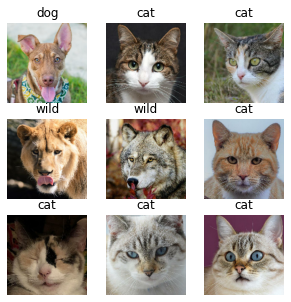

In [10]:
# visualizing data
plt.figure(figsize=(5, 5))
for img, label in train_dataset.take(1):
  for i in range(9):
    pos = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")

In [11]:
from keras.applications.vgg16 import VGG16

In [12]:
conv_base=VGG16(
                weights='imagenet',
                include_top=False, 
                input_shape=(150,150,3)
                )

58900480/58889256 [==============================] - 0s 0us/step


In [13]:
# configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


In [14]:
# create a data augmentation model
data_augmentation = tf.keras.Sequential([layers.RandomFlip('horizontal'),
                                         layers.RandomRotation(0.2),
                                         layers.RandomRotation(factor=(-0.2,0.3))
                                         ])

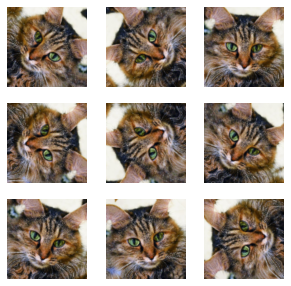

In [15]:
for img, _ in train_dataset.take(1): # Take 1 batch out
  plt.figure(figsize=(5, 5)) 
  first_img = img[0] # Take 1 image out from the batch
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_img, 0))
    plt.imshow(augmented_image[0] / 255) # Rescale pixel value
    plt.axis('off')

In [16]:
# preprocess input using the function from the pre-trained model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

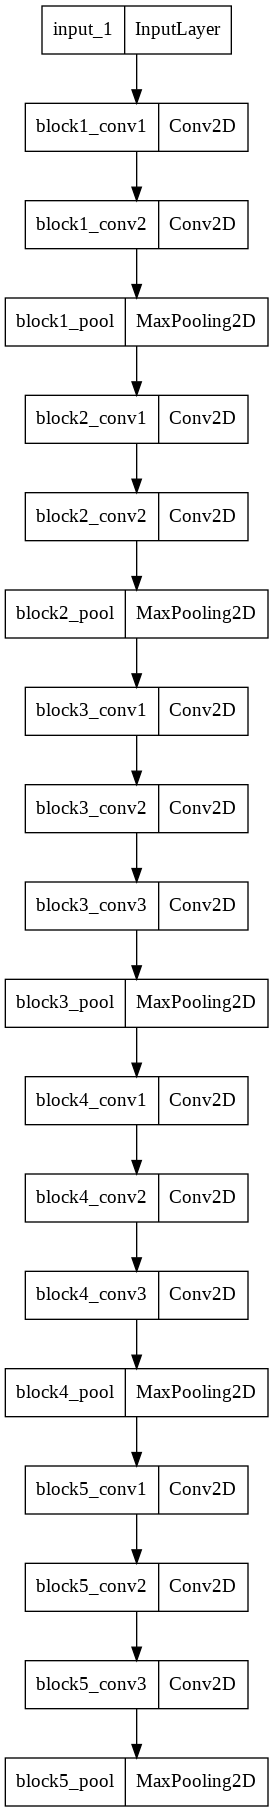

In [18]:
tf.keras.utils.plot_model(conv_base)

In [42]:
x=train_dataset.take(1)
print(x)

<TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [19]:
img_batch, label_batch = next(iter(train_dataset))
print('img_batch shape = ',img_batch.shape)
feature_batch=conv_base(img_batch)

# batchsize, width, height, layer
print('feature_batch shape = ',feature_batch.shape)

img_batch shape =  (32, 150, 150, 3)
feature_batch shape =  (32, 4, 4, 512)


In [20]:
# freeze the base model
conv_base.trainable = False

In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [22]:
# GlobalAveragePooling2D aggregate width and height into 1 dimension
# transforming the previous (64, 4, 4, 512) into (64, 512)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [23]:
len(class_names)

3

In [24]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [25]:
# use functional API to create the entire model, including the input pipeline and model
inputs = tf.keras.Input(shape=(150,150,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = conv_base(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 150, 150, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [26]:
# compile

base_learning_rate = 0.0001
opt=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)

model.compile(optimizer=opt, metrics=['accuracy'],
              loss=tf.keras.losses.SparseCategoricalCrossentropy())

In [27]:
# get model performance before training
initial_epochs = 10

loss_0, acc_0 = model.evaluate(validation_dataset)
print('loss:', loss_0)
print('accuracy:', acc_0)

12/12 [==============================] - 55s 797ms/step - loss: 11.3238 - accuracy: 0.5480
loss: 11.323845863342285
accuracy: 0.5480226278305054


In [28]:
logdir = os.path.join("logs", 'model')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[tensorboard_callback])

Epoch 1/10
132/132 [==============================] - 343s 3s/step - loss: 6.5131 - accuracy: 0.5074 - val_loss: 4.8785 - val_accuracy: 0.6384
Epoch 2/10
132/132 [==============================] - 29s 210ms/step - loss: 3.3620 - accuracy: 0.6483 - val_loss: 2.5025 - val_accuracy: 0.7684
Epoch 3/10
132/132 [==============================] - 29s 210ms/step - loss: 2.0778 - accuracy: 0.7576 - val_loss: 1.2878 - val_accuracy: 0.8955
Epoch 4/10
132/132 [==============================] - 28s 207ms/step - loss: 1.3282 - accuracy: 0.8148 - val_loss: 0.9157 - val_accuracy: 0.9322
Epoch 5/10
132/132 [==============================] - 133s 1s/step - loss: 1.1255 - accuracy: 0.8419 - val_loss: 0.7659 - val_accuracy: 0.9435
Epoch 6/10
132/132 [==============================] - 28s 208ms/step - loss: 0.9064 - accuracy: 0.8624 - val_loss: 0.8037 - val_accuracy: 0.9266
Epoch 7/10
132/132 [==============================] - 80s 604ms/step - loss: 0.8943 - accuracy: 0.8748 - val_loss: 0.6728 - val_accura

In [30]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 2s 289ms/step - loss: 0.6635 - accuracy: 0.9688
Test accuracy : 0.96875


Predictions:
 [2 1 2 2 1 0 1 1 0 0 2 0 2 0 1 2 1 1 1 1 0 0 0 2 2 0 0 0 0 2 0 1]
Labels:
 [2 1 2 2 1 2 1 1 0 0 2 0 2 0 1 2 1 1 1 1 0 0 0 2 2 0 0 0 0 2 0 1]


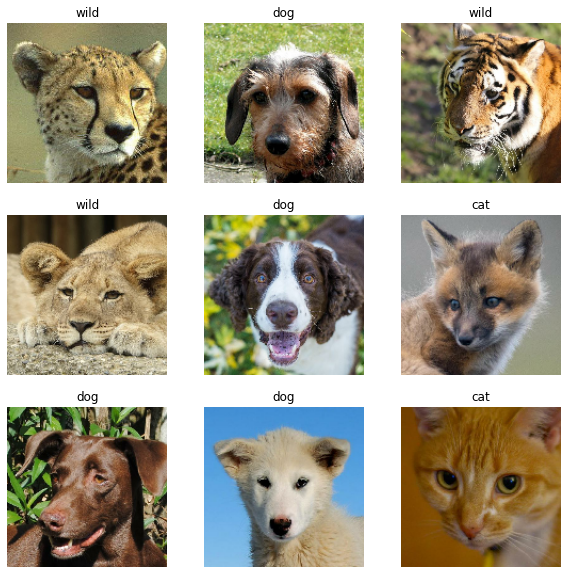

In [31]:
# retrieve a batch of images from the test set

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch) # predict on 1 batch
pred_label = np.argmax(predictions, axis=1) # get the class index with max predictions

# compare prediction and labels
print('Predictions:\n', pred_label)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[pred_label[i]])
  plt.axis("off")

In [32]:
# Saving the model for Future Inferences
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")

# New Section